## **Machine Learning Project for Bank Credit Dataset**


Bank Marketing Dataset in OpenML (https://www.openml.org/d/1461) is chosen for this project.
The selected dataset contains client data from a Portuguese bank's marketing campaign, aiming to predict whether a client will subscribe to a term deposit.

**Column Definitions:**


*   job:	Occupation
*   marital:	Marital status
*   education:	Education level
*   default:	Has credit in default? (yes/no)
*   balance:	Average yearly bank balance (in euros)
*   housing:	Has a housing loan? (yes/no)
*   loan:	Has a personal loan? (yes/no)
*   contact:	Contact communication type (cellular, telephone)
*   day:	Last contact day of the month
*   month:	Last contact month of the year
*   duration:	Duration of last contact in seconds
*   campaign:	Number of contacts during the current campaign
*   pdays: Days passed since last contact from a previous campaign (999 / -1 = no previous contact)
*  previous:	Number of contacts before this campaign
*  poutcome:	Outcome of the previous marketing campaign (success, failure, unknown)
*   target:	Has the client subscribed to a term deposit? (1 = no, 2 = yes)




### **Data Load Steps**

*   OpenML Python API is used.
*   Column names were renamed.
*   Target variable was appended to the DataFrame.

In [51]:
# Import sklearn object
from sklearn.feature_selection import SelectFromModel,RFE
from sklearn.model_selection import train_test_split, cross_val_score, KFold,StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

In [28]:
!pip install openml
import openml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Access data with API Key
openml.config.apikey = 'd1d7d235b5af2860d5e4962ed225765e'

# Connect data
dataset = openml.datasets.get_dataset(1461)

# Construct dataFrame
data_tuple = dataset.get_data(target=dataset.default_target_attribute)

X = data_tuple[0]
y = data_tuple[1]
df = X.copy()

# Rename the columns
df.columns = [
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
    'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
    'previous', 'poutcome'
]

df['target'] = y

# Check dataframe
print(df.head(5))

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no   2143.0     yes   no   
1   44    technician   single  secondary      no     29.0     yes   no   
2   33  entrepreneur  married  secondary      no      2.0     yes  yes   
3   47   blue-collar  married    unknown      no   1506.0     yes   no   
4   33       unknown   single    unknown      no      1.0      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome target  
0  unknown    5   may     261.0         1   -1.0       0.0  unknown      1  
1  unknown    5   may     151.0         1   -1.0       0.0  unknown      1  
2  unknown    5   may      76.0         1   -1.0       0.0  unknown      1  
3  unknown    5   may      92.0         1   -1.0       0.0  unknown      1  
4  unknown    5   may     198.0         1   -1.0       0.0  unknown      1  


In [29]:
# df is copied for future usage.
df_copy = df.copy()

### **Data Cleaning and Preprocessing**


*  Dataset is checked for null and duplicated values.
*  Categorical and numeric variables are determined.
*  Values of -1 and 999 in pdays column are removed since they do not indicate contact days value.
* Ordinal encoding is used for categorical columns with ordinal order.
* For nomical categorical variables one-hot encoding is used.
* Target variable converted to binary values.


In [30]:
# Check for null and dublicates values
print(df.isnull().sum())
print(df.duplicated().sum())

# Check data statistics
print(df.describe())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
target       0
dtype: int64
0
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

         

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  uint8   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  float64 
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  uint8   
 10  month      45211 non-null  category
 11  duration   45211 non-null  float64 
 12  campaign   45211 non-null  uint8   
 13  pdays      45211 non-null  float64 
 14  previous   45211 non-null  float64 
 15  poutcome   45211 non-null  category
 16  target     45211 non-null  category
dtypes: category(10), float64(4), uint8(3)
memory usage: 1.9 MB


In [32]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
  print(col,":", df[col].unique())

job : ['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', ..., 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
Length: 12
Categories (12, object): ['admin.' < 'blue-collar' < 'entrepreneur' < 'housemaid' ... 'student' <
                          'technician' < 'unemployed' < 'unknown']
marital : ['married', 'single', 'divorced']
Categories (3, object): ['divorced' < 'married' < 'single']
education : ['tertiary', 'secondary', 'unknown', 'primary']
Categories (4, object): ['primary' < 'secondary' < 'tertiary' < 'unknown']
default : ['no', 'yes']
Categories (2, object): ['no' < 'yes']
housing : ['yes', 'no']
Categories (2, object): ['no' < 'yes']
loan : ['no', 'yes']
Categories (2, object): ['no' < 'yes']
contact : ['unknown', 'cellular', 'telephone']
Categories (3, object): ['cellular' < 'telephone' < 'unknown']
month : ['may', 'jun', 'jul', 'aug', 'oct', ..., 'jan', 'feb', 'mar', 'apr', 'sep']
Length: 12
Categories (12, object): ['apr' < 'aug' < 'de

In [33]:
# Make target column binary regarding category values
df['target'] = df['target'].astype(str).str.strip()
df['target'] = df['target'].map({'1': 0, '2': 1})

df.target.unique()

array([0, 1])

In [34]:
# Converting pdays column into ordinal categories since it has mostly null values (later analysis has details on this issue)
print(df.pdays.isin([-1, 999]).sum())

def mapping_pdays(num):
    if num in [-1, 999]:
        return "no_contact"
    elif num <= 30:
        return "recent"
    elif num <= 90:
        return "1_3_months"
    else:
        return "over_3_months"

df['pdays_cat'] = df['pdays'].apply( mapping_pdays)
df = df.drop('pdays', axis=1)


# Filter ordinal categorical columns and determine order
ordinal_cols = ['education', 'month', 'poutcome','pdays_cat']
for x in ordinal_cols:
    df[x] = df[x].astype(str)
    df[x] = df[x].str.strip()

ordinal_order = [
    ['primary', 'secondary', 'tertiary', 'unknown'],
    ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
    ['failure', 'other', 'success', 'unknown'],
    ['no_contact', 'recent', '1_3_months', 'over_3_months']
]

# Apply ordinal encoding
encoder = OrdinalEncoder(categories=ordinal_order)
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

# Converting non-numeric variables into numeric variables
nominal_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact']

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)


# Split features and target
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

36954


### **Data Distribution and Correlation Between Variables**



* Distribution in target is checked. Since '0' values has 88% of the whole dataset, StratifiedKFold is chosen to ensure the distribution in k-folds. Still this unbalanced in target values can create bias, must be considered.
* The distribution of X variables in histograms indicates that some variables (housing, loan, default) are not evenly distributed,
* Features like balance, duration, and campaign are right-skewed with outliers.
* pdays_cat and poutcome has mostly null/no contact values.
* Overall, data is inbalanced but results of this model should be carefully used considering data quality before implementing.
* Correlation between X variables and correlation between variables and target are also checked.
* Variables which has low correlation with target (<|0.05|) indicates weak relation and 13 of 28 has it. In feature selection this variables most likely to be eliminated.
* Only high correlation between X variables are between pdays_cat and poutcome. One of them will be eliminated in further feature selection methods.

In [35]:
# Check y value distribution
print(y.value_counts(normalize=True))

target
0    0.883015
1    0.116985
Name: proportion, dtype: float64


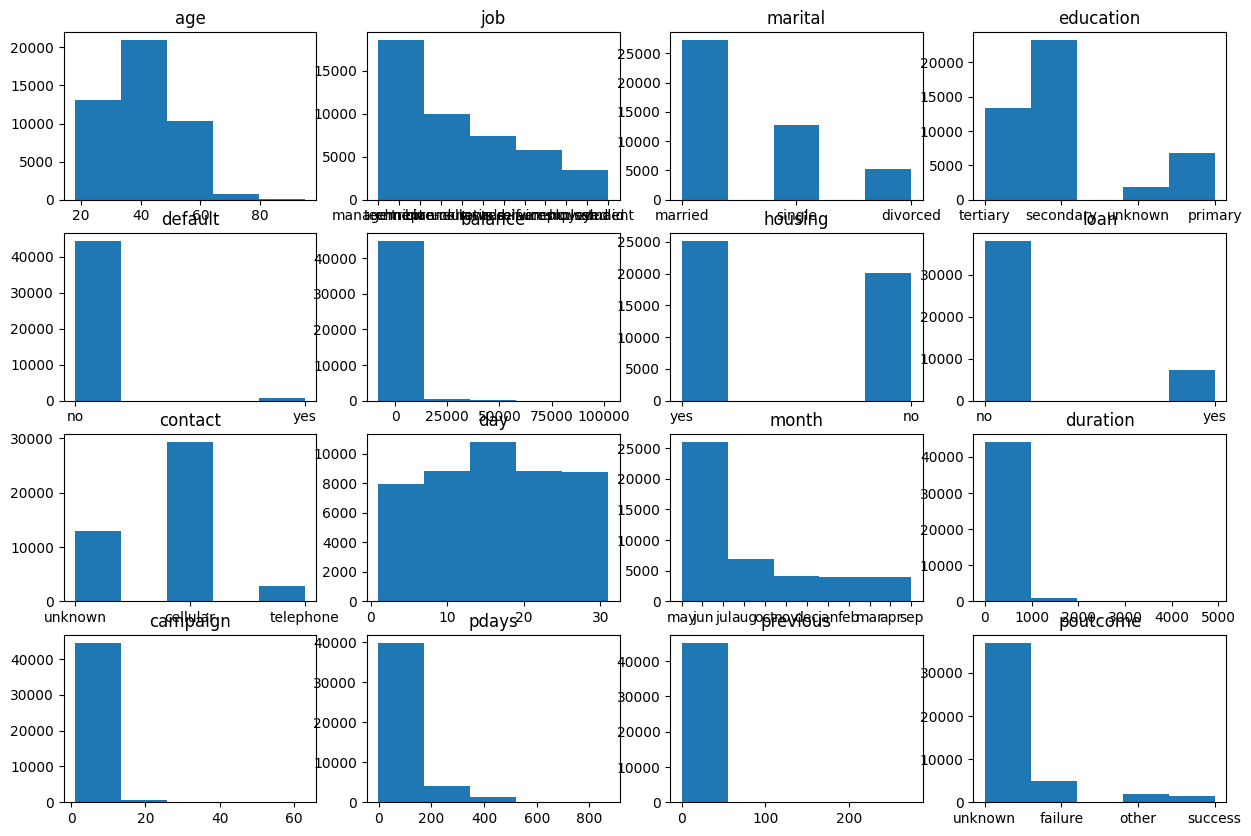

In [36]:
# Check x value distribution with original data set
import matplotlib.pyplot as plt

columns = df_copy.drop("target", axis=1).columns

fig,ax = plt.subplots(4,4, figsize=(15, 10))

for i in range(4):
  for j in range(4):
    ax[i,j].hist(df_copy[columns[i*4+j]],bins = 5 )
    ax[i, j].set_title(columns[i*4+j])

plt.show()

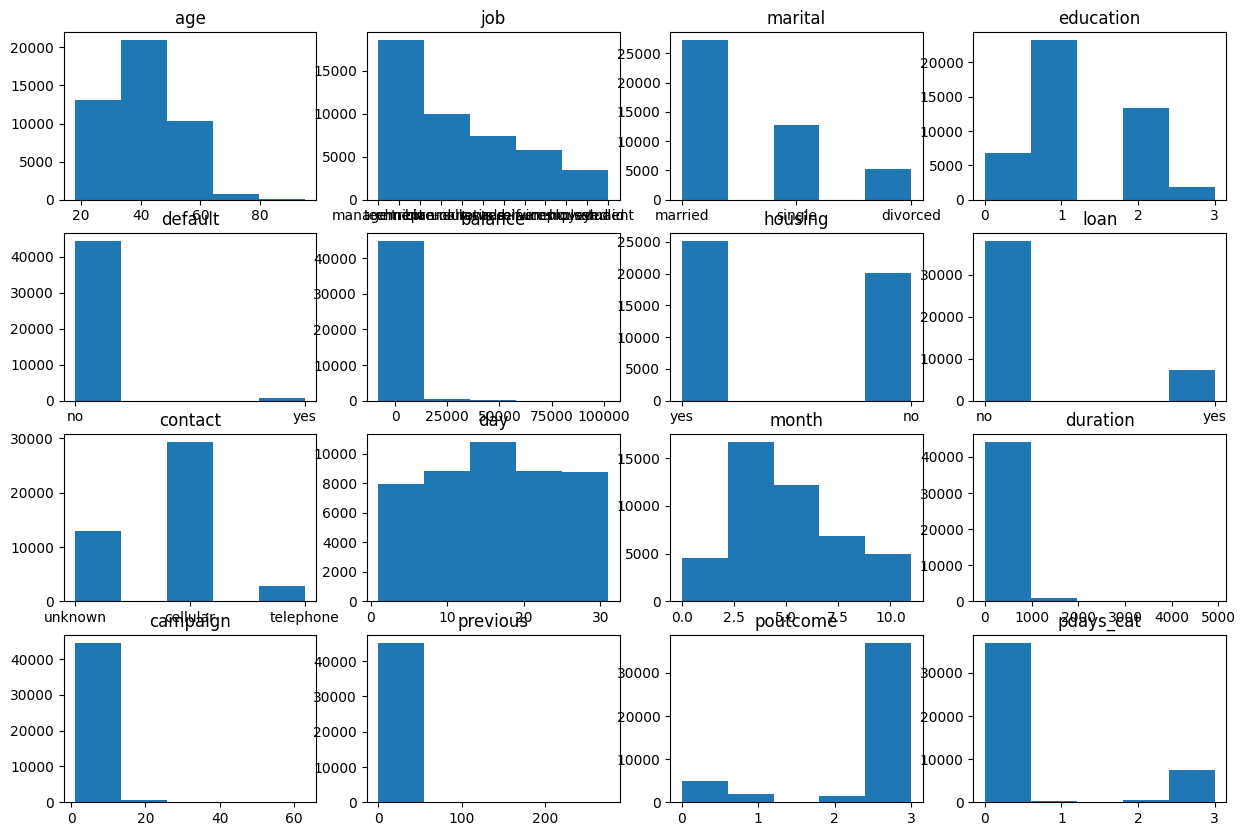

In [37]:
# Check x value distribution with processed dataset
import matplotlib.pyplot as plt

columns = df.drop("target", axis=1).columns

fig,ax = plt.subplots(4,4, figsize=(15, 10))

for i in range(4):
  for j in range(4):
    ax[i,j].hist(df[columns[i*4+j]],bins = 5 )
    ax[i, j].set_title(columns[i*4+j])

plt.show()

In [38]:
# Control correlation with y
corr = df_encoded.corr(numeric_only=True)['target'].sort_values(ascending=False)

print(corr)

target               1.000000
duration             0.394521
pdays_cat            0.161269
previous             0.093236
job_retired          0.079245
job_student          0.076897
education            0.066241
marital_single       0.063526
balance              0.052838
job_management       0.032919
age                  0.025155
job_unemployed       0.020390
month                0.018717
contact_telephone    0.014042
job_self-employed    0.000855
job_unknown          0.000267
job_technician      -0.008970
job_housemaid       -0.015195
job_entrepreneur    -0.019662
default_yes         -0.022419
job_services        -0.027864
day                 -0.028348
marital_married     -0.060260
loan_yes            -0.068185
job_blue-collar     -0.072083
campaign            -0.073172
poutcome            -0.077840
housing_yes         -0.139173
contact_unknown     -0.150935
Name: target, dtype: float64


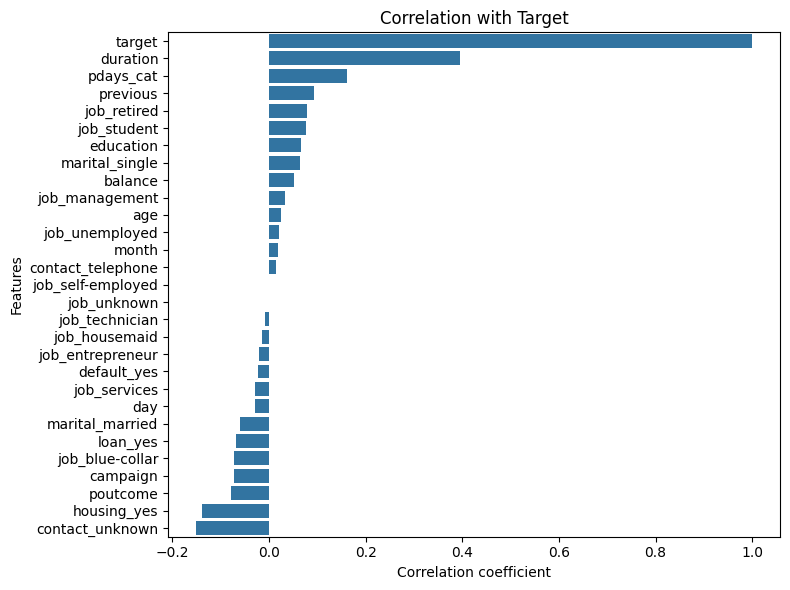

In [39]:
# Visualize
plt.figure(figsize=(8,6))
sns.barplot(x=corr.values, y=corr.index)
plt.title('Correlation with Target')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [40]:
# Determine number of low correlated variables with target
print(X.shape)
low_corr_cols = corr[abs(corr) <= 0.05].index
X_low_corr = X.drop(low_corr_cols, axis=1)
print(X_low_corr.shape)

(45211, 28)
(45211, 15)


In [41]:
# Determine number of high correlated variables
print(X.shape)
high_corr_cols = corr[(abs(corr) >= 0.8) & (abs(corr) < 1)].index
X_high_corr = X.drop(high_corr_cols, axis=1)
print(X_high_corr.shape)

(45211, 28)
(45211, 28)


In [42]:
corr_matrix = df_encoded.corr(numeric_only=True)
high_corr = []

for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i!=j and abs(corr_matrix.loc[i,j]) > 0.8:
            pair = tuple(sorted((i,j)))
            if pair not in high_corr:
                high_corr.append(pair)

print(high_corr)

[('pdays_cat', 'poutcome')]


### **Feature Selection**



*  Feature selection methods are used for improved model performance.
*  Correlation, random forest, L1 and L2 were used. With RFE technique, best 10 feature is selected.
* The common features of those models are selected for model, keeping model much simple and effective.
* pdays_cat was excluded, mostly likely its predictive power was already captured by poutcome.
* Variables like age, and balance were eliminated due to weak correlation patterns.
* duration remained since it has strong positive correlation with target, but  it has potential risk for data leakage risk since is the length of the last contact in the current campaign.















In [43]:
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify=y)

In [44]:
# Correlation with target
corr_train = pd.concat([X_train, y_train.rename("target")], axis=1) \
               .corr(numeric_only=True)["target"].drop("target")
corr_selected_features = set(corr_train[abs(corr_train) >= 0.05].index)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=300, random_state=42)
random_forest.fit(X_train, y_train)
rf_selected_features = set(X_train.columns[random_forest.feature_importances_.argsort()[-10:]])

# L1 selection
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

l1_selected_features = set()
for c_val in [1, 0.1, 0.01]:
    l1 = LogisticRegression(penalty='l1', solver='liblinear', C=c_val,
                             max_iter=2000, random_state=42)
    l1.fit(X_train_scaled, y_train)
    selected = set(X_train.columns[l1.coef_[0] != 0])
    l1_selected_features.update(selected)

# L2 + RFE selection
l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=2000, random_state=42)
rfe = RFE(l2, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)
l2_selected_features = set(X_train.columns[rfe.support_])

# Common features
common_features = corr_selected_features & rf_selected_features & l1_selected_features & l2_selected_features

print("Correlation selected:", sorted(corr_selected_features))
print("Random Forest selected:", sorted(rf_selected_features))
print("L1 selected (all C tests):", sorted(l1_selected_features))
print("L2 selected:", sorted(l2_selected_features))
print("\nCommon features:", sorted(common_features))

Correlation selected: ['balance', 'campaign', 'contact_unknown', 'duration', 'education', 'housing_yes', 'job_blue-collar', 'job_retired', 'job_student', 'loan_yes', 'marital_married', 'marital_single', 'pdays_cat', 'poutcome', 'previous']
Random Forest selected: ['age', 'balance', 'campaign', 'day', 'duration', 'education', 'housing_yes', 'month', 'poutcome', 'previous']
L1 selected (all C tests): ['age', 'balance', 'campaign', 'contact_telephone', 'contact_unknown', 'day', 'default_yes', 'duration', 'education', 'housing_yes', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'loan_yes', 'marital_married', 'marital_single', 'month', 'pdays_cat', 'poutcome', 'previous']
L2 selected: ['campaign', 'contact_unknown', 'duration', 'education', 'housing_yes', 'job_retired', 'loan_yes', 'marital_married', 'pdays_cat', 'poutcome']

Common features: ['ca

### **Model Selection**


* Since we have a classification problem, classification models are used, and their performance was evaluated using accuracy scores.
* XGBoostClassifier achieved the highest accuracy among all models.
* Models with five common features showed accuracy close to those using the full set (other jupyter notebooks in this project has those models and scores), feature selection simplied the model without losing predictivity.
* Final model with whole dataset has a confusion matrix with gih false negatives. This indicates that model has generally chosose '0' over '1'. The inequtiy in target's distribution may have a result like that.
* When we compare validation scores among the models, XGBClassifier is the chosen model since it has high CV score and low variance.





In [45]:
# Make list of common features
selected_cols = [c for c in sorted(list(common_features)) if c in X_train.columns]

# Remove eliminated features from X_train and X_test
X_train_selected = X_train[list(common_features)].copy()
X_test_selected  = X_test[list(common_features)].copy()


# Create the pipeline and cross validation object
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('Classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create alternative models to select best model
search_space = [
    {
        'Classifier': [LogisticRegression(solver='liblinear')],
        'Classifier__C': [0.01, 0.1, 1, 10],
        'Classifier__penalty': ['l1', 'l2']
    },
    {
        'Classifier': [KNeighborsClassifier()],
        'Classifier__n_neighbors': [3, 5, 7]
    },
    {
        'Classifier': [RandomForestClassifier(random_state=42)],
        'Classifier__n_estimators': [100, 300],
        'Classifier__max_depth': [3, 5, 7]
    },
    {
        'Classifier': [DecisionTreeClassifier(random_state=42)],
        'Classifier__max_depth': [3, 5, 7],
        'Classifier__criterion': ['gini', 'entropy']
    },
    {
        'Classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)],
        'Classifier__n_estimators': [50, 100],
        'Classifier__max_depth': [3, 5],
        'Classifier__learning_rate': [0.01, 0.1]
    }
]

In [46]:
# GridSearch Execution
grid = GridSearchCV(pipeline, search_space, cv=skf, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)


print("Best Classifier:", grid.best_estimator_.named_steps['Classifier'].__class__.__name__)
print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best Classifier: XGBClassifier
Best Params: {'Classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'Classifier__learning_rate': 0.1, 'Classifier__max_depth': 3, 'Classifier__n_estimators': 50}
Best CV Accuracy: 0.900741119835167


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:09:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [47]:
# Append results
results = pd.DataFrame(grid.cv_results_)

# Create model_name
results['model_name'] = results['param_Classifier'].astype(str)

# Sort by test_score
best_models = results.sort_values(by='mean_test_score', ascending=False)

# Keep each model's best score
unique_models = best_models.drop_duplicates(subset='model_name', keep='first')

# Select Top 3 model
best_models = unique_models.head(3)

# Print Results
print("Top 3 different models:")
for i, row in best_models.iterrows():
    print("Model:", row['model_name'])
    print("Mean CV Accuracy:", round(row['mean_test_score'], 4))
    print("Params:", row['params'])

Top 3 different models:
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)
Mean CV Accuracy: 0.9007
Params: {'Classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsa

In [53]:
## Appliying best 3 result's paramaters to compare models
models = {
    "XGB (lr=0.1, depth=3, n=50)": XGBClassifier(
        learning_rate=0.1, max_depth=3, n_estimators=50,
        eval_metric="logloss", random_state=42
    ),
    "RandomForest (depth=7, n=100)": RandomForestClassifier(
        max_depth=7, n_estimators=100, random_state=42
    ),
    "DecisionTree (gini, depth=5)": DecisionTreeClassifier(
        criterion="gini", max_depth=5, random_state=42
    ),
}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    y_prob = mdl.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name} | Acc: {acc:.4f} | ROC-AUC: {auc:.4f}")
    print(confusion_matrix(y_test, y_pred), "\n")

XGB (lr=0.1, depth=3, n=50) | Acc: 0.8984 | ROC-AUC: 0.9118
[[7841  144]
 [ 775  283]] 

RandomForest (depth=7, n=100) | Acc: 0.8953 | ROC-AUC: 0.9103
[[7945   40]
 [ 907  151]] 

DecisionTree (gini, depth=5) | Acc: 0.8986 | ROC-AUC: 0.8552
[[7784  201]
 [ 716  342]] 



In [48]:
# Test Accuracy of Best Model with x_test
xgb = XGBClassifier(
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=50,
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb)
])

pipeline.fit(X_train_selected, y_train)
test_score = pipeline.score(X_test_selected, y_test)

print("Final Test Accuracy:", round(test_score, 4))

Final Test Accuracy: 0.8995


In [50]:
selected = [c for c in X.columns if c in common_features]

if not selected:
    raise ValueError("No selected features found in X. Check 'common_features' vs X.columns.")

#  final XGB pipeline
final_xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=50,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', final_xgb)
])

# Fit & Predict
pipeline.fit(X[selected], y)
y_pred = pipeline.predict(X[selected])

# Metrics
cm = confusion_matrix(y, y_pred)
acc = accuracy_score(y, y_pred)

print("Used features:", selected)
print("Confusion Matrix:\n", cm)
print("Accuracy:", round(acc, 4))
print("Accuracy:", round(acc, 4))

Used features: ['education', 'duration', 'campaign', 'poutcome', 'housing_yes']
Confusion Matrix:
 [[38968   954]
 [ 3444  1845]]
Accuracy: 0.9027
Accuracy: 0.9027
